<a href="https://colab.research.google.com/github/seirah-yang/BootCamp/blob/main/CDE_%EB%AC%B8%EC%84%9C%EC%9E%84%EB%B2%A0%EB%94%A9_%5Bcde_small_v2%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U "pyarrow>=21" "datasets>=2.20" "transformers>=4.41"

In [ ]:
!pip install transformers datasets --upgrade > /dev/null

In [1]:
import transformers

model = transformers.AutoModel.from_pretrained("jxm/cde-small-v2", trust_remote_code=True)
tokenizer = transformers.AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jxm/cde-small-v2:
- model.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Disabled 23 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v2.4e1d021a6c3fd7ce8aa0a7204057eee5ae61d390.model.BiEncoder'>
Disabled 46 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v2.4e1d021a6c3fd7ce8aa0a7204057eee5ae61d390.model.ContextualDocumentEmbeddingTransformer'>


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

corpus_df = pd.read_csv("/content/drive/MyDrive/cde-small-v2/Training.csv")
queries_df = pd.read_csv("/content/drive/MyDrive/cde-small-v2/validation.csv")

In [4]:
print(pd.read_csv("/content/drive/MyDrive/cde-small-v2/Training.csv", nrows=5))

  profile_id          talk_id persona_id human_persona computer_persona  \
0  Pro_05349  Pro_05349_00053  Pro_05349     A02 | G02              C01   
1  Pro_05349  Pro_05349_00049  Pro_05349     A02 | G02              C01   
2  Pro_05349  Pro_05349_00077  Pro_05349     A02 | G02              C01   
3  Pro_05349  Pro_05349_00064  Pro_05349     A02 | G02              C01   
4  Pro_05349  Pro_05349_00039  Pro_05349     A02 | G02              C01   

    emotion_id emotion_type emotion_situation  \
0  S06_D02_E18          E18         S06 | D02   
1  S06_D02_E18          E18         S06 | D02   
2  S06_D02_E18          E18         S06 | D02   
3  S06_D02_E18          E18         S06 | D02   
4  S06_D02_E18          E18         S06 | D02   

                                         human_say_1  \
0                          일은 왜 해도 해도 끝이 없을까? 화가 난다.   
1     이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.   
2  회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...   
3  직장에서 막내라는 이유로 나에게만 온갖 심부름을 

In [5]:
corpus = corpus_df.iloc[:,0].dropna().astype(str).tolist()
queries = queries_df.iloc[:,0].dropna().astype(str).tolist()

In [6]:
query_prefix = "search_query: "
document_prefix = "search_document: "

In [7]:
import random

corpus_size = model.config.transductive_corpus_size
idx = random.choices(range(len(corpus)), k=corpus_size)  # 복원추출
minicorpus_docs = [corpus[i] for i in idx]

def process_ex_document(x: str) -> str:
    return ("search_document: " + x).strip()

minicorpus_docs = [process_ex_document(t) for t in minicorpus_docs]

In [8]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

mc_tok = tokenizer(
    minicorpus_docs,
    truncation=True, padding=True, max_length=768, return_tensors="pt"
).to(device)

Using device: cuda


## Stage 1: Gather dataset embeddings

CDE works by first getting a set of embeddings from corpus documents that is intended to be representative of the overall corpus. We first sample a number of documents from the corpus (this model is trained with 512 documents from each context) and get their embeddings from our first-stage model.

CDE 모델은 방대한 문서를 한꺼번에 다루기보다, **코퍼스를 대표할 수 있는 작은 묶음(mini-corpus)**을 먼저 추출하는 방식으로 작동합니다.
쉽게 말해, 전체 책장을 훑어보는 대신 그 책장의 성격을 잘 보여줄 만한 책 몇 권을 먼저 골라내는 거죠.

이 모델은 기본적으로 512개의 문서를 하나의 컨텍스트 단위로 삼아 학습되었습니다. 그래서 실제로 쓸 때도 코퍼스에서 문서를 무작위로 샘플링해 512개 정도를 뽑습니다. 그리고 나서 **1단계 모델(first-stage model)**을 이용해 이 문서들의 임베딩(숫자로 표현된 의미 벡터)을 만듭니다.

이 과정을 통해 얻은 임베딩은 이후 단계에서 문서 검색이나 질의 응답을 더 똑똑하게 수행하기 위한 기초 자료가 됩니다.

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

model.to(device).eval()

mc_tok = tokenizer(
    minicorpus_docs,
    truncation=True, padding=True, max_length=768, return_tensors="pt"
)
mc_tok = {k: v.to(device) for k, v in mc_tok.items()}

import torch
from tqdm.autonotebook import tqdm

batch_size = 32

dataset_embeddings = []
for i in tqdm(range(0, mc_tok["input_ids"].size(0), batch_size)):
    batch = {k: v[i:i+batch_size] for k, v in mc_tok.items()}
    with torch.no_grad():
        emb = model.first_stage_model(**batch)
    dataset_embeddings.append(emb)

dataset_embeddings = torch.cat(dataset_embeddings, dim=0)

device: cuda


  0%|          | 0/16 [00:00<?, ?it/s]

## Stage 2: Embed in context

Now that we have dataset embeddings, we can use them to embed queries and documents like normal. We just need to provide an extra argument (`dataset_embeddings` in the CDE code).

**데이터셋 임베딩(dataset embeddings)**을 만들었으니, 이를 활용해 **질의(query)**와 **문서(document)**도 보통 임베딩하듯이 변환할 수 있습니다.
다만, CDE 모델을 사용할 때는 여기에 추가 인자를 하나 더 넣어줘야 합니다. 바로 앞에서 얻은 dataset_embeddings을 함께 전달해야 합니다.

즉, 일반적인 임베딩 과정과 크게 다르지 않지만, CDE는 dataset_embeddings을 컨텍스트로 삼아야 합니다.

In [15]:
docs = corpus[:32]
docs = [process_ex_document(doc) for doc in docs]

# 토큰화
docs_tok = tokenizer(
    [document_prefix + doc for doc in docs],
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
).to(device)

# 2단계 임베딩
with torch.no_grad():
    doc_embeddings = model.second_stage_model(
        input_ids=docs_tok["input_ids"],
        attention_mask=docs_tok["attention_mask"],
        dataset_embeddings=dataset_embeddings,
    )

# L2 정규화
doc_embeddings = torch.nn.functional.normalize(doc_embeddings, p=2, dim=1)

W0923 08:08:33.566000 977 torch/_inductor/utils.py:1436] [0/0_1] Not enough SMs to use max_autotune_gemm mode


In [16]:
queries_subset = queries[:32]

queries_tok = tokenizer(
    [query_prefix + q for q in queries_subset],
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
).to(device)

with torch.no_grad():
    query_embeddings = model.second_stage_model(
        input_ids=queries_tok["input_ids"],
        attention_mask=queries_tok["attention_mask"],
        dataset_embeddings=dataset_embeddings,
    )

query_embeddings = torch.nn.functional.normalize(query_embeddings, p=2, dim=1)


In [17]:
query_embeddings, doc_embeddings

(tensor([[ 0.0019,  0.0538,  0.0202,  ..., -0.0444,  0.0484,  0.0176],
         [ 0.0019,  0.0538,  0.0202,  ..., -0.0444,  0.0484,  0.0176],
         [ 0.0019,  0.0538,  0.0202,  ..., -0.0444,  0.0484,  0.0176],
         ...,
         [-0.0166,  0.0852,  0.0281,  ...,  0.0138,  0.0788, -0.0202],
         [-0.0166,  0.0852,  0.0281,  ...,  0.0138,  0.0788, -0.0202],
         [-0.0166,  0.0852,  0.0281,  ...,  0.0138,  0.0788, -0.0202]],
        device='cuda:0'),
 tensor([[-0.0096,  0.0592,  0.0401,  ..., -0.0201,  0.0667,  0.0170],
         [-0.0096,  0.0592,  0.0401,  ..., -0.0201,  0.0667,  0.0170],
         [-0.0096,  0.0592,  0.0401,  ..., -0.0201,  0.0667,  0.0170],
         ...,
         [-0.0113,  0.0609,  0.0597,  ..., -0.0242,  0.0671,  0.0181],
         [-0.0113,  0.0609,  0.0597,  ..., -0.0242,  0.0671,  0.0181],
         [-0.0177,  0.0581,  0.0445,  ..., -0.0151,  0.0724,  0.0300]],
        device='cuda:0'))

## Compute scores between queries and documents

Since we normalized our embeddings above, we can compute their cosine similarities by doing a simple matrix multiplication.

<Axes: >

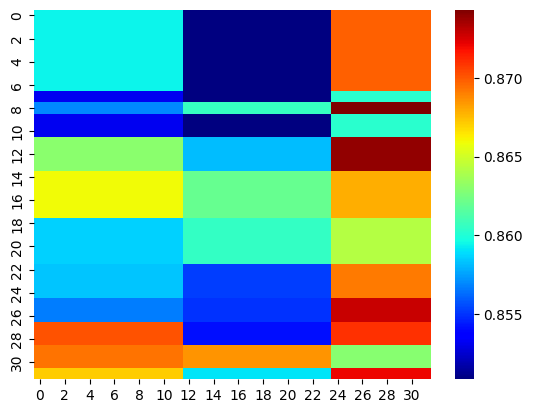

In [18]:
import seaborn as sns

sns.heatmap((doc_embeddings @ query_embeddings.T).cpu(), cmap="jet")

In [19]:
torch.save(doc_embs,   "cde_doc_emb.pt")
np.save("cde_docs.npy", np.array(docs, dtype=object))  # 원문 텍스트
if query_embs is not None:
    torch.save(query_embs, "cde_query_emb.pt")

print("\n[SAVED] cde_doc_emb.pt, cde_docs.npy", end="")
if query_embs is not None:
    print(", cde_query_emb.pt", end="")
print(" 저장완료")

NameError: name 'doc_embs' is not defined